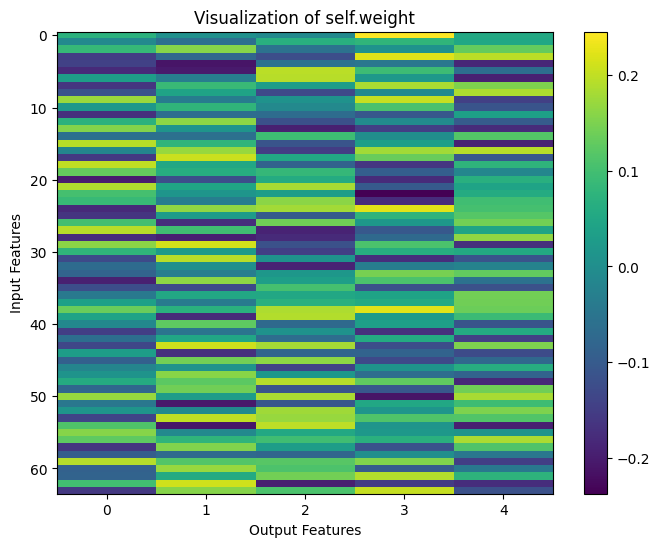

In [2]:
import torch
import matplotlib.pyplot as plt

class NormedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = torch.nn.functional.normalize(x, dim=1).mm(torch.nn.functional.normalize(self.weight, dim=0))
        return out

# Create an instance of the model
model = NormedLinear(in_features=64, out_features=5)

# Get the weight tensor from the model
weight_data = model.weight.data.numpy()

# Plot the figure
plt.figure(figsize=(8, 6))
plt.imshow(weight_data, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Visualization of self.weight')
plt.xlabel('Output Features')
plt.ylabel('Input Features')
plt.show()


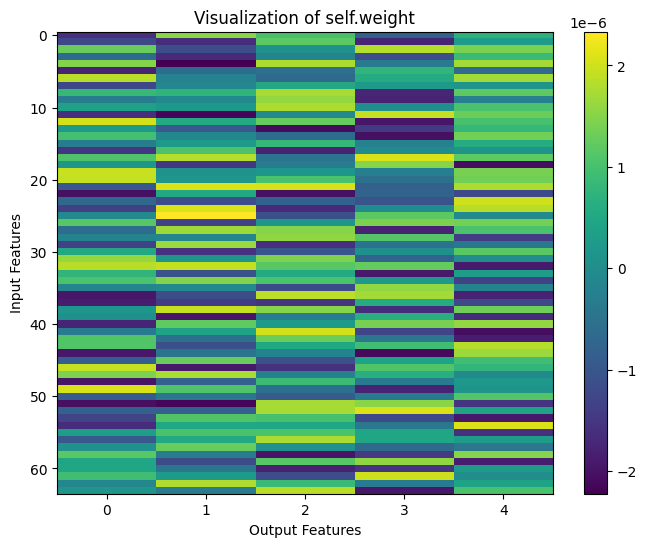

In [3]:
import torch
import matplotlib.pyplot as plt

class NormedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5) #.mul_(1e5)

    def forward(self, x):
        out = torch.nn.functional.normalize(x, dim=1).mm(torch.nn.functional.normalize(self.weight, dim=0))
        return out

# Create an instance of the model
model = NormedLinear(in_features=64, out_features=5)

# Get the weight tensor from the model
weight_data = model.weight.data.numpy()

# Plot the figure
plt.figure(figsize=(8, 6))
plt.imshow(weight_data, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Visualization of self.weight')
plt.xlabel('Output Features')
plt.ylabel('Input Features')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter

from fedml_api.model.basic.group_normalization import GroupNorm2d

import random

__all__ = ['ResNet_s', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.planes = planes
                self.in_planes = in_planes
                # self.shortcut = LambdaLayer(lambda x: F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes // 4, planes // 4), "constant", 0))
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, (planes - in_planes) // 2, (planes - in_planes) // 2), "constant", 0))
                
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module): 

    def __init__(self, block, num_blocks, num_experts, num_classes=10, reduce_dimension=False, layer2_output_dim=None,
                 layer3_output_dim=None, use_norm=False, returns_feat=False, use_experts=None, s=30):
        super(ResNet_s, self).__init__()
        
        self.in_planes = 16
        self.num_experts = num_experts

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.in_planes = self.next_in_planes

        if layer2_output_dim is None:
            if reduce_dimension:
                layer2_output_dim = 24
            else:
                layer2_output_dim = 32

        if layer3_output_dim is None:
            if reduce_dimension:
                layer3_output_dim = 48
            else:
                layer3_output_dim = 64

        self.layer2s = nn.ModuleList([self._make_layer(block, layer2_output_dim, num_blocks[1], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        self.layer3s = nn.ModuleList([self._make_layer(block, layer3_output_dim, num_blocks[2], stride=2) for _ in range(num_experts)])
        self.in_planes = self.next_in_planes
        
        if use_norm:
            self.linears = nn.ModuleList([NormedLinear(layer3_output_dim, num_classes) for _ in range(num_experts)])
        else:
            self.linears = nn.ModuleList([nn.Linear(layer3_output_dim, num_classes) for _ in range(num_experts)])
            s = 1

        if use_experts is None:
            self.use_experts = list(range(num_experts))
        elif use_experts == "rand":
            self.use_experts = None
        else:
            self.use_experts = [int(item) for item in use_experts.split(",")]

        self.s = s

        self.apply(_weights_init)
        # self.moe_pool = nn.AdaptiveAvgPool2d((8, 8))
        # self.moe_nn = nn.Linear(16*8*8, self.num_experts, bias=False)
        # nn.init.constant_(self.moe_nn.weight, 1)
        self.softmax = nn.Softmax(dim=1)

        self.moe = False

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        self.next_in_planes = self.in_planes
        for stride in strides:
            layers.append(block(self.next_in_planes, planes, stride))
            self.next_in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def _hook_before_iter(self):
        assert self.training, "_hook_before_iter should be called at training time only, after train() is called"
        count = 0
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                if module.weight.requires_grad == False:
                    module.eval()
                    count += 1

        if count > 0:
            print("Warning: detected at least one frozen BN, set them to eval state. Count:", count)

    def _separate_part(self, x, ind):
        out = x
        out = (self.layer2s[ind])(out)
        out = (self.layer3s[ind])(out)
        # self.feat_before_GAP.append(out)
        print("out:",out.shape)
        out = F.avg_pool2d(out, out.size()[3])
        print("later out:",out.shape)
        out = out.view(out.size(0), -1)
        # self.feat.append(out)
        out = (self.linears[ind])(out)
        out = out * self.s
        return out

    def forward(self, x, output_all=False, ano=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        
        outs = []
        self.feat = []
        self.logits = outs
        self.feat_before_GAP = []
        
        if self.use_experts is None:
            use_experts = random.sample(range(self.num_experts), self.num_experts - 1)
        else:
            use_experts = self.use_experts
        
        for ind in use_experts:
            # print(f"expert:{ind}; out: {out}")
            ano.append(out)
            o = self._separate_part(out, ind)
            # out_min = torch.min(o)
            # out_max = torch.max(o)
            # o = (o - out_min)/(out_max - out_min)
            # o = o * 2 - 1
            outs.append(o)

        # self.feat = torch.stack(self.feat, dim=1)
        # self.feat_before_GAP = torch.stack(self.feat_before_GAP, dim=1)

        # if self.moe:
        #     moe_weight = self.moe_pool(out)
        #     moe_weight = moe_weight.view(moe_weight.size(0), -1)
        #     moe_weight = self.moe_nn(moe_weight)
        #     moe_weight = self.softmax(moe_weight).unsqueeze(-1)
        #
        #     self.moe_weight = moe_weight
        #     final_out = torch.stack(outs, dim=-1) @ moe_weight
        #     final_out = final_out.squeeze(-1)
        # else:
        final_out = torch.stack(outs, dim=1).mean(dim=1)

        if output_all:
            return final_out, outs
        else:
            return final_out, ano


In [5]:
backbone = ResNet_s(BasicBlock, [5, 5, 5], num_classes=100, reduce_dimension=True, layer2_output_dim=None, layer3_output_dim=None, use_norm=True, num_experts=3)


In [6]:
x = torch.randn(16, 3, 32,32)
hs = []

_, hs = backbone(x,ano=hs)
# print(hs[0]==hs[1])
# print(hs[1]==hs[2])

out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])
out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])
out: torch.Size([16, 48, 8, 8])
later out: torch.Size([16, 48, 1, 1])


In [7]:
hs[0].data_ptr()

117423104

In [8]:
hs[1].data_ptr()

117423104

In [9]:
x = hs[0]
x.data_ptr()

117423104

In [10]:
y = torch.randn(2,4)
y

tensor([[ 1.0175, -0.6542, -1.3308,  2.1123],
        [ 0.1441,  0.5807, -0.8785, -0.8480]])

In [11]:
y.data_ptr()

83819776

In [12]:
y_ = y
y_ = torch.nn.Linear(4,2)(y_)
y_

tensor([[0.1534, 0.4157],
        [0.8424, 0.2417]], grad_fn=<AddmmBackward0>)

In [13]:
y_.data_ptr()

112124480

In [14]:
y.data_ptr()

83819776

In [15]:
y = torch.nn.Linear(4,2)(y)
y

tensor([[-1.3429,  1.6516],
        [-0.1115,  0.5352]], grad_fn=<AddmmBackward0>)

In [16]:
y.data_ptr()

117379840

In [17]:
y = torch.randn(1,3)
y.data_ptr()


88046272

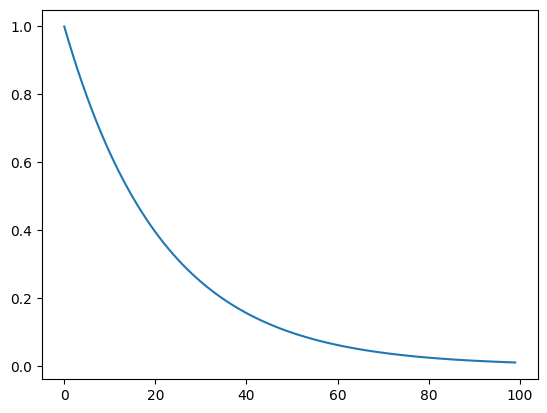

In [18]:
import matplotlib.pyplot as plt
import numpy as np

img_max = 1
imb_factor = 0.01
cls_idx = np.arange(100)
cls_num = 100
num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
plt.plot(cls_idx, num)
plt.show()

In [19]:
def f():
    return {"aa":12}


In [20]:
a = f()
a

{'aa': 12}

In [21]:
a["aa"]

12

In [22]:
import torch
data = torch.randn(2,3,4).cuda()

# 将data拆分为x[0]和x[1]
x,y = torch.chunk(data, chunks=2, dim=0)

# 输出x[0]和x[1]
print(x.cpu().squeeze(0).shape)

torch.Size([3, 4])


In [23]:
x = torch.split(data, split_size_or_sections=2, dim=0)
x

(tensor([[[ 0.7716,  0.6663, -0.1833, -0.4457],
          [-1.2821,  0.3102,  0.5046,  0.6837],
          [ 0.4147,  0.8801,  0.3807,  1.9363]],
 
         [[ 0.2593, -0.8865, -0.1927,  0.4799],
          [ 1.4384, -0.2472,  1.4222, -0.6956],
          [-0.7462, -0.3920, -0.4976, -0.7424]]], device='cuda:0'),)

In [24]:
import torch
import torch.nn as nn

# 定义一个简单的神经网络
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建一个实例
model = SimpleNN()

# 获取所有参数并将其堆叠成一个向量
parameters_vector = torch.cat([param.view(-1) for param in model.parameters()])

print(parameters_vector)


print(model.cpu().state_dict())

tensor([ 0.2380, -0.0562,  0.1475,  0.1619,  0.0777,  0.2913, -0.1876, -0.3039,
         0.1164,  0.0591, -0.2782,  0.2829, -0.2918, -0.2637, -0.0675,  0.0358,
        -0.2670,  0.2871, -0.1892, -0.2478, -0.1608,  0.1113,  0.1460, -0.1180,
        -0.0784,  0.2432, -0.0393,  0.2402,  0.2220,  0.2202, -0.2180,  0.0656,
         0.0530, -0.2493,  0.1405,  0.0749,  0.2735, -0.2603,  0.1314, -0.2835,
         0.1114,  0.1737, -0.0346,  0.1110,  0.1814, -0.2695,  0.2527,  0.0533,
        -0.1415, -0.1295,  0.1170,  0.2855,  0.2937, -0.0332, -0.0892, -0.0257,
        -0.2868, -0.3397, -0.2041, -0.1539,  0.2794], grad_fn=<CatBackward0>)
OrderedDict([('fc1.weight', tensor([[ 0.2380, -0.0562,  0.1475,  0.1619,  0.0777,  0.2913, -0.1876, -0.3039,
          0.1164,  0.0591],
        [-0.2782,  0.2829, -0.2918, -0.2637, -0.0675,  0.0358, -0.2670,  0.2871,
         -0.1892, -0.2478],
        [-0.1608,  0.1113,  0.1460, -0.1180, -0.0784,  0.2432, -0.0393,  0.2402,
          0.2220,  0.2202],
       

In [25]:
[p for p in model.cpu().parameters()]

[Parameter containing:
 tensor([[ 0.2380, -0.0562,  0.1475,  0.1619,  0.0777,  0.2913, -0.1876, -0.3039,
           0.1164,  0.0591],
         [-0.2782,  0.2829, -0.2918, -0.2637, -0.0675,  0.0358, -0.2670,  0.2871,
          -0.1892, -0.2478],
         [-0.1608,  0.1113,  0.1460, -0.1180, -0.0784,  0.2432, -0.0393,  0.2402,
           0.2220,  0.2202],
         [-0.2180,  0.0656,  0.0530, -0.2493,  0.1405,  0.0749,  0.2735, -0.2603,
           0.1314, -0.2835],
         [ 0.1114,  0.1737, -0.0346,  0.1110,  0.1814, -0.2695,  0.2527,  0.0533,
          -0.1415, -0.1295]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1170,  0.2855,  0.2937, -0.0332, -0.0892], requires_grad=True),
 Parameter containing:
 tensor([[-0.0257, -0.2868, -0.3397, -0.2041, -0.1539]], requires_grad=True),
 Parameter containing:
 tensor([0.2794], requires_grad=True)]

In [26]:
torch.cat([e.view(-1) for e in model.cpu().state_dict().values()])

tensor([ 0.2380, -0.0562,  0.1475,  0.1619,  0.0777,  0.2913, -0.1876, -0.3039,
         0.1164,  0.0591, -0.2782,  0.2829, -0.2918, -0.2637, -0.0675,  0.0358,
        -0.2670,  0.2871, -0.1892, -0.2478, -0.1608,  0.1113,  0.1460, -0.1180,
        -0.0784,  0.2432, -0.0393,  0.2402,  0.2220,  0.2202, -0.2180,  0.0656,
         0.0530, -0.2493,  0.1405,  0.0749,  0.2735, -0.2603,  0.1314, -0.2835,
         0.1114,  0.1737, -0.0346,  0.1110,  0.1814, -0.2695,  0.2527,  0.0533,
        -0.1415, -0.1295,  0.1170,  0.2855,  0.2937, -0.0332, -0.0892, -0.0257,
        -0.2868, -0.3397, -0.2041, -0.1539,  0.2794])

In [27]:
def gram_schmidt(vectors):
    basis = []
    for v in vectors:
        w = v - sum(torch.dot(v, b) / torch.dot(b, b) * b for b in basis)
        basis.append(w)
    return torch.stack(basis)

# 生成两个向量
v1 = torch.tensor([1.0, 2.0, 3.0])
v2 = torch.tensor([4.0, 5.0, 6.0])

# 正交化
orthogonal_basis = gram_schmidt([v1, v2])

# 得到正交化后的向量
v1_orthogonal = orthogonal_basis[0]
v2_orthogonal = orthogonal_basis[1]

print("正交化后的v1:", v1_orthogonal)
print("正交化后的v2:", v2_orthogonal)


正交化后的v1: tensor([1., 2., 3.])
正交化后的v2: tensor([ 1.7143,  0.4286, -0.8571])


In [28]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
g = torch.load("fedml_experiments/clsimb_fedavg/g.pth")
l = torch.load("fedml_experiments/clsimb_fedavg/l.pth")
g_cat = torch.cat([g[k].view(-1) for k in g.keys() if "num_batches_tracked" not in k]).cpu()
l_cat = torch.cat([l[k].view(-1) for k in l.keys() if "num_batches_tracked" not in k]).cpu()

FileNotFoundError: [Errno 2] No such file or directory: 'fedml_experiments/clsimb_fedavg/g.pth'

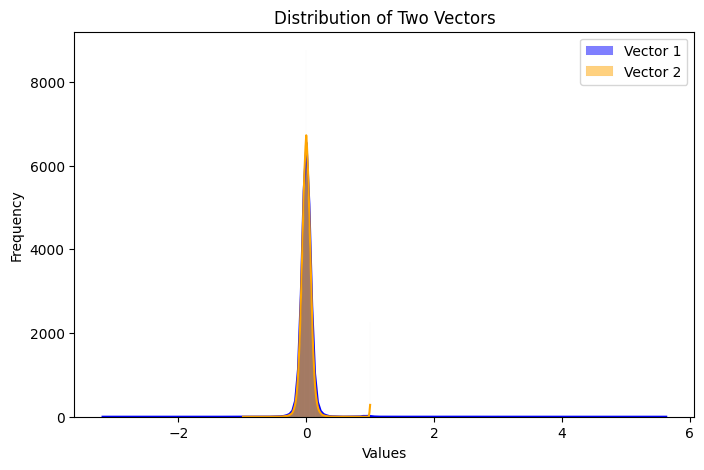

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.histplot(l_cat, kde=True, color='blue', label='Vector 1')
sns.histplot(g_cat, kde=True, color='orange', label='Vector 2')

plt.title('Distribution of Two Vectors')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

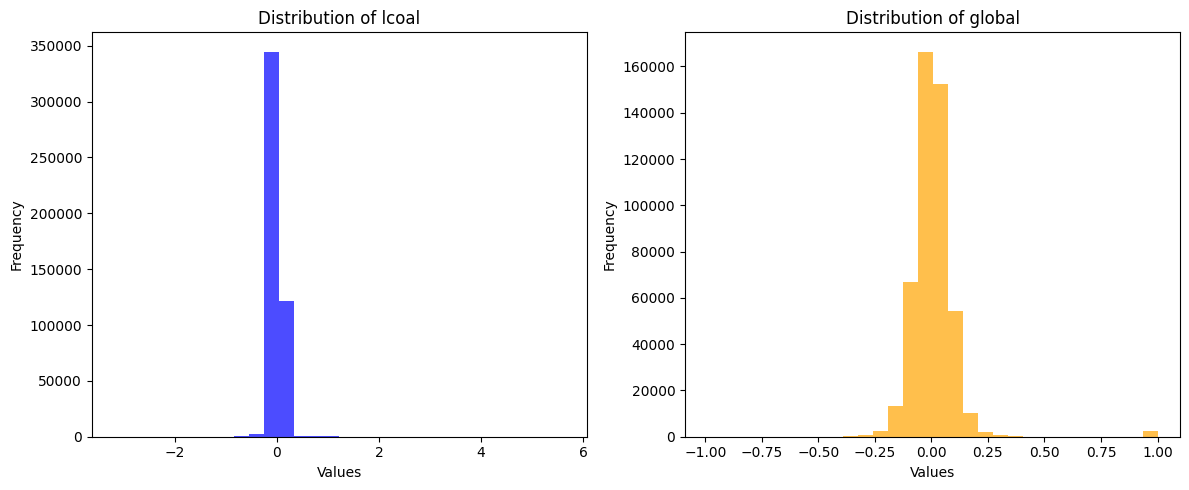

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Vector 1
ax1.hist(l_cat, bins=30, color='blue', alpha=0.7)
ax1.set_title('Distribution of lcoal')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for Vector 2
ax2.hist(g_cat, bins=30, color='orange', alpha=0.7)
ax2.set_title('Distribution of global')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

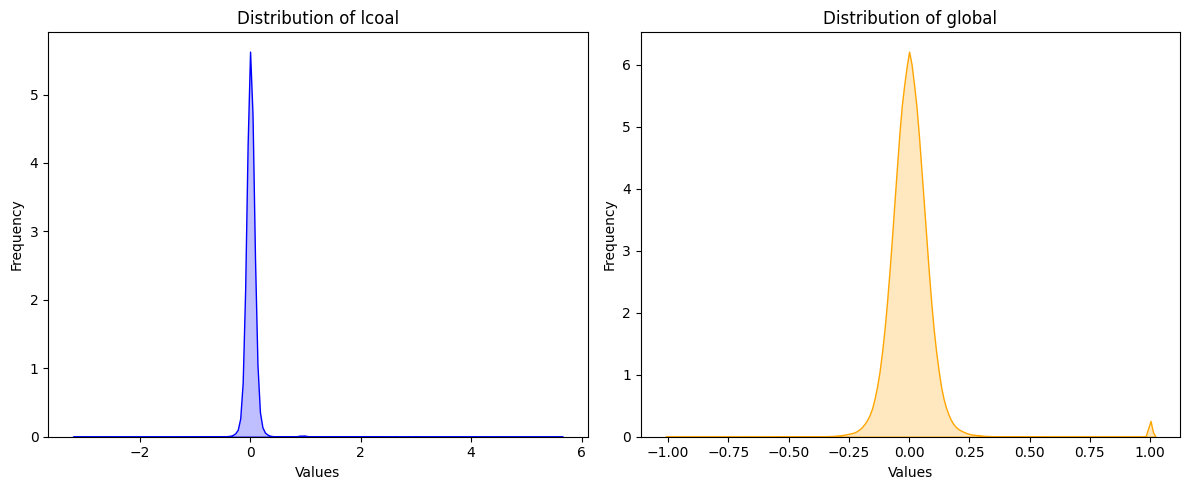

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for Vector 1
# ax1.hist(l_cat, bins=30, color='blue', alpha=0.7)
sns.kdeplot(l_cat, ax=ax1, label='local', color='blue', fill=True)
ax1.set_title('Distribution of lcoal')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

# Plot histogram for Vector 2
# ax2.hist(g_cat, bins=30, color='orange', alpha=0.7)
sns.kdeplot(g_cat, ax=ax2, label='global', color='orange', fill=True)
ax2.set_title('Distribution of global')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
def kde_model(path, label, func=None):
    if func is None:
        model_state_dict = torch.load(path)
    else: 
        model_state_dict = func(path)
    # model_state_dict = np.array()
    param_cat_vec = torch.cat([model_state_dict[k].view(-1) for k in model_state_dict.keys() if "bn" not in k]).cpu()
    # plot
    plt.figure(figsize=(8, 5))
    sns.kdeplot(param_cat_vec, label=label, color='blue', fill=True)

    plt.title(f'Kernel Density Estimate of {label}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()  

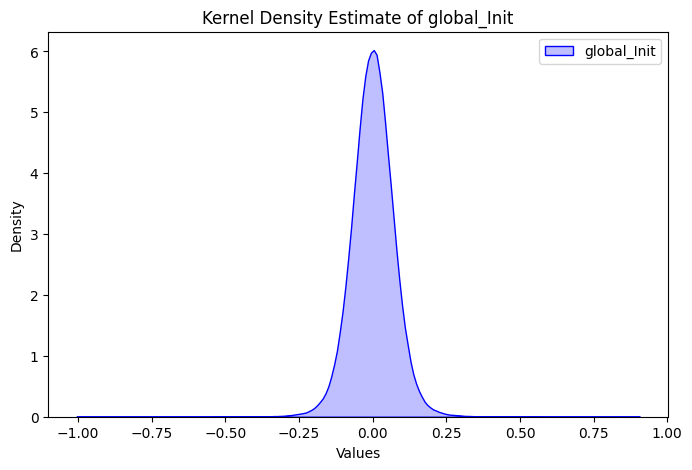

In [ ]:
kde_model("fedml_experiments/clsimb_fedavg/g.pth", "global_Init")

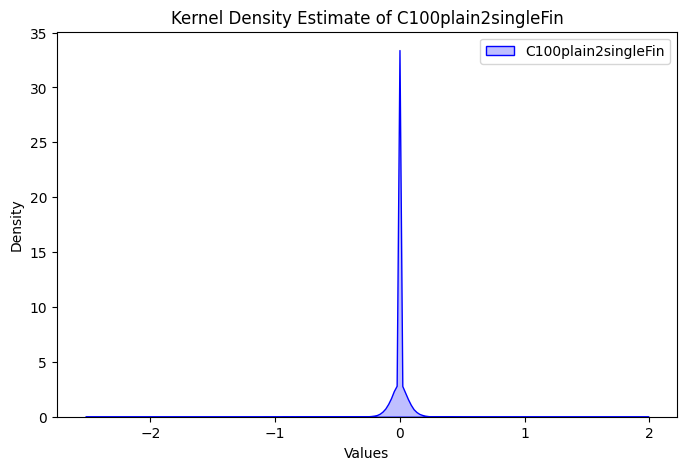

In [ ]:
def load_check(path):
    checkpoint = torch.load(path)
    return checkpoint['model']

kde_model("/root/Federated-Long-tailed-Learning/checkpoint/C100_plain_2SingleFIN/round_80000_global.pth", "C100plain2singleFin", func=load_check)

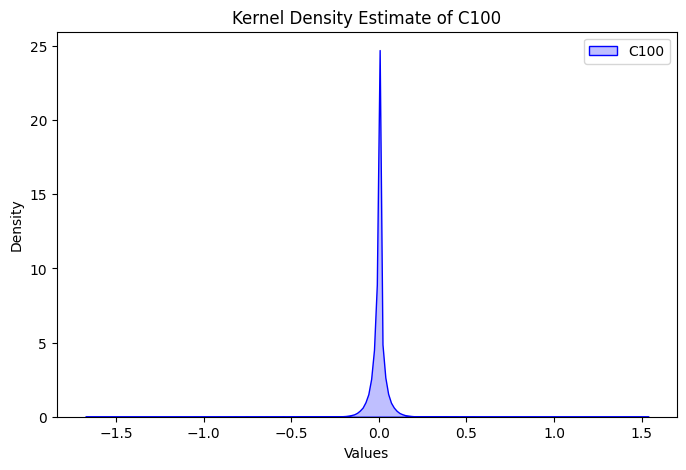

In [ ]:
def load_check(path):
    checkpoint = torch.load(path)
    return checkpoint['model']

kde_model("/root/Federated-Long-tailed-Learning/checkpoint/C100/round_2500_global.pth", "C100", func=load_check)

In [ ]:
model_state_dict = load_check("/root/Federated-Long-tailed-Learning/checkpoint/C100/round_2500_global.pth")
param_cat_vec = torch.cat([model_state_dict[k].view(-1) for k in model_state_dict.keys()]).cpu()
param_cat_vec

tensor([-0.1914, -0.2683, -0.2386,  ..., -0.0037, -0.0255, -0.0194])

In [ ]:
param_cat_vec.argmax()

tensor(496)

In [ ]:
for idx,k in enumerate(model_state_dict.keys()):
    print(idx, k, f"min: {model_state_dict[k].min().cpu()}", f"max: {model_state_dict[k].max().cpu()}")

0 backbone.conv1.weight min: -1.0152263641357422 max: 1.5311769247055054
1 backbone.bn1.weight min: 4.0340371924685314e-05 max: 1.8034396171569824
2 backbone.bn1.bias min: -0.5155225396156311 max: 1.6232551336288452
3 backbone.bn1.running_mean min: -1.0846004486083984 max: 1.190495491027832
4 backbone.bn1.running_var min: 2.217574319729465e-06 max: 24.480464935302734
5 backbone.bn1.num_batches_tracked min: 10778 max: 10778
6 backbone.layer1.0.conv1.weight min: -0.5741850137710571 max: 0.5974284410476685
7 backbone.layer1.0.bn1.weight min: 0.18342918157577515 max: 0.6198747754096985
8 backbone.layer1.0.bn1.bias min: -0.44939786195755005 max: 0.5775245428085327
9 backbone.layer1.0.bn1.running_mean min: -3.8172757625579834 max: 2.721400499343872
10 backbone.layer1.0.bn1.running_var min: 0.30716651678085327 max: 8.495078086853027
11 backbone.layer1.0.bn1.num_batches_tracked min: 10778 max: 10778
12 backbone.layer1.0.conv2.weight min: -0.5212969183921814 max: 0.47211119532585144
13 backbone

In [29]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Parameter


__all__ = ['ResNet_s', 'resnet20', 'resnet32', 'resnet44', 'resnet56', 'resnet110', 'resnet1202']

def make_divisible(v, divisor=8, min_value=1):
    """
    forked from slim:
    https://github.com/tensorflow/models/blob/\
    0344c5503ee55e24f0de7f37336a6e08f10976fd/\
    research/slim/nets/mobilenet/mobilenet.py#L62-L69
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def _weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class NormedLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NormedLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)

    def forward(self, x):
        out = F.normalize(x, dim=1).mm(F.normalize(self.weight, dim=0))
        return out

class LambdaLayer(nn.Module):

    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes // 4, planes // 4), "constant",
                                                  0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet_s(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10, use_norm=False, head_tail_ratio=0.3, transfer_strength=1.0, phase_train=False, epoch_thresh=0, KD=False):
        super(ResNet_s, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        if use_norm:
            self.fc = NormedLinear(64, num_classes)
        else:
            self.fc = nn.Linear(64, num_classes)
        self.apply(_weights_init)

        self.KD = KD

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x, epoch=0, target=None):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)

        out = self.layer3(out)
        out = self.avgpool(out)
        # out = F.avg_pool2d(out, out.size()[3])
        feats = out.view(out.size(0), -1)
        out = self.fc(feats)

        if self.KD:
            return out, feats
        else:
            return out

    # for FedAlign
    def extract_feature(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)  # B x 16 x 32 x 32
        x = self.layer1(x)  # B x 16 x 32 x 32
        x2 = self.layer2(x)  # B x 32 x 16 x 16
        x3 = self.layer3(x2)  # B x 64 x 8 x 8

        x = self.avgpool(x3)  # B x 64 x 1 x 1
        x_f = x.view(x.size(0), -1)  # B x 64
        x = self.fc(x_f)  # B x num_classes
        if self.KD == True:
            return x_f, x
        else:
            return [x2, x3], x

    def reuse_feature(self, x, ):
        x2 = x[:, :make_divisible(x.shape[1] * self.width_mult)]
        x3 = self.layer3(x2)
        return [x2, x3]



In [30]:
import torch
import torch.nn as nn
# from .CosNormClassifier import CosNorm_Classifier
# from utils import *

import pdb

class MetaEmbedding_Classifier(nn.Module):
    
    def __init__(self, feat_dim=2048, num_classes=1000):
        super(MetaEmbedding_Classifier, self).__init__()
        self.num_classes = num_classes
        self.fc_hallucinator = nn.Linear(feat_dim, num_classes)
        self.fc_selector = nn.Linear(feat_dim, feat_dim)
        self.cosnorm_classifier = nn.Linear(feat_dim, num_classes)
        
    def forward(self, x, centroids, *args):
        
        # storing direct feature
        direct_feature = x.clone()

        batch_size = x.size(0)
        feat_size = x.size(1)
        
        # set up visual memory
        x_expand = x.clone().unsqueeze(1).expand(-1, self.num_classes, -1)
        centroids_expand = centroids.clone().unsqueeze(0).expand(batch_size, -1, -1)
        keys_memory = centroids.clone() 
        
        # computing reachability
        dist_cur = torch.norm(x_expand - centroids_expand, 2, 2)
        values_nn, labels_nn = torch.sort(dist_cur, 1) # min to max
        scale = 10.0
        reachability = (scale / values_nn[:, 0]).unsqueeze(1).expand(-1, feat_size)

        # computing memory feature by querying and associating visual memory
        values_memory = self.fc_hallucinator(x.clone())
        values_memory = values_memory.softmax(dim=1) # into probability distribution
        memory_feature = torch.matmul(values_memory, keys_memory)

        # computing concept selector
        concept_selector = self.fc_selector(x.clone())
        concept_selector = concept_selector.tanh() 
        x = reachability * (direct_feature + concept_selector * memory_feature)

        # storing infused feature
        infused_feature = concept_selector * memory_feature
        
        logits = self.cosnorm_classifier(x)

        return logits, [direct_feature, infused_feature]
    

def init_weights(model, weights_path, caffe=False, classifier=False):  
    """Initialize weights"""
    print('Pretrained %s weights path: %s' % ('classifier' if classifier else 'feature model',
                                              weights_path))    
    weights = torch.load(weights_path)
    if not classifier:
        if caffe:
            weights = {k: weights[k] if k in weights else model.state_dict()[k] 
                       for k in model.state_dict()}
        else:
            weights = weights['state_dict_best']['feat_model']
            weights = {k: weights['module.' + k] if 'module.' + k in weights else model.state_dict()[k] 
                       for k in model.state_dict()}
    else:      
        weights = weights['state_dict_best']['classifier']
        weights = {k: weights['module.fc.' + k] if 'module.fc.' + k in weights else model.state_dict()[k] 
                   for k in model.state_dict()}
    model.load_state_dict(weights)   
    return model

def create_classifer(feat_dim=64, num_classes=100, stage1_weights=False, test=False, *args):
    print('Loading Meta Embedding Classifier.')
    clf = MetaEmbedding_Classifier(feat_dim, num_classes)

    if not test:
        if stage1_weights:
            clf.fc_hallucinator = init_weights(model=clf.fc_hallucinator,
                                                    weights_path='/root/OpenLongTailRecognition-OLTR/logs/%s/stage1/final_model_checkpoint.pth' % dataset,
                                                    classifier=True)
        else:
            print('Random initialized classifier weights.')

    return clf



In [31]:

def load_checkpoint(create_model, path):
    checkpoint = torch.load(path)
    args = checkpoint['args']

    # Avoid randomness of cuda, but it will slow down the training
    if "cifar" in args.dataset:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    device = torch.device("cuda:" + str(args.gpu) if torch.cuda.is_available() else "cpu")

    torch.set_printoptions(threshold=np.inf)

    # load dataset
    # create model
    model = create_model(args, model_name=args.model, output_dim=100)
    model.load_state_dict(checkpoint['model'])
    return model

In [32]:
import numpy as  np

def resnet32(args, num_classes=10, use_norm=False): 
    return ResNet_s(BasicBlock, [5, 5, 5], num_classes=num_classes, use_norm=use_norm, KD=args.contrast)

def create_model(args, model_name, output_dim):
    model = resnet32(args, num_classes=output_dim)
    return model

model = load_checkpoint(create_model, "/root/Federated-Long-tailed-Learning/checkpoint/C100_Last/round_1_global.pth")

In [33]:
print(model.fc)

Linear(in_features=64, out_features=100, bias=True)


In [34]:

def create_classifer(feat_dim=64, num_classes=100, stage1_weights=False, test=False, *args):
    print('Loading Meta Embedding Classifier.')
    clf = MetaEmbedding_Classifier(feat_dim, num_classes)

    if not test:
        if True:
            clf.fc_hallucinator = init_weights(model=clf.fc_hallucinator,
                                                    weights_path='/root/OpenLongTailRecognition-OLTR/logs/%s/stage1/final_model_checkpoint.pth' % dataset,
                                                    classifier=True)
        else:
            print('Random initialized classifier weights.')

    return clf

In [35]:
clf = MetaEmbedding_Classifier(64, 100)

clf.fc_hallucinator = init_weights(model=clf.fc_hallucinator,
                                    weights_path='/root/Federated-Long-tailed-Learning/checkpoint/C100_Last/round_1_global.pth',
                                    classifier=True)

Pretrained classifier weights path: /root/Federated-Long-tailed-Learning/checkpoint/C100_Last/round_1_global.pth


KeyError: 'state_dict_best'

In [36]:

def init_weights(model, weights_path, caffe=False, classifier=False):  
    """Initialize weights"""
    print('Pretrained %s weights path: %s' % ('classifier' if classifier else 'feature model',
                                              weights_path))    
    weights = load_checkpoint(create_model, weights_path)
    if not classifier:
        if caffe:
            weights = {k: weights[k] if k in weights else model.state_dict()[k] 
                       for k in model.state_dict()}
        else:
            weights = weights['state_dict_best']['feat_model']
            weights = {k: weights['module.' + k] if 'module.' + k in weights else model.state_dict()[k] 
                       for k in model.state_dict()}
    else:      
        weights = weights['fc']
        weights = {k: weights['module.fc.' + k] if 'module.fc.' + k in weights else model.state_dict()[k] 
                   for k in model.state_dict()}
    model.load_state_dict(weights)   
    return model

In [37]:
model=clf.fc_hallucinator
model

Linear(in_features=64, out_features=100, bias=True)

In [38]:
weights_path='/root/Federated-Long-tailed-Learning/checkpoint/C100_Last/round_1_global.pth'
weights = load_checkpoint(create_model, weights_path)
weights


ResNet_s(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affin

In [39]:
weights = {k: weights['fc.' + k] if 'fc.' + k in weights else model.state_dict()[k] for k in model.state_dict()}
# model.state_dict().keys()

TypeError: argument of type 'ResNet_s' is not iterable

In [43]:
weights.fc.weight = torch.nn.Parameter(model.state_dict()['weight'])
# model.state_dict()

In [44]:
model.state_dict()['weight'] = weights.fc.weight

In [2]:
import torch
weights_path = "/root/Federated-Long-tailed-Learning/checkpoint/C100_Last/round_2100_global.pth"
weights = torch.load(weights_path)['model']
# clf.fc_hallucinator.weight = weights
weights

OrderedDict([('conv1.weight',
              tensor([[[[ 1.5076e-03,  9.4667e-04,  1.2504e-03],
                        [ 1.8817e-03,  1.6657e-03,  1.7763e-03],
                        [ 1.7302e-03,  2.1671e-03,  1.9899e-03]],
              
                       [[ 1.3063e-03,  9.4087e-04,  3.9831e-04],
                        [ 6.1222e-04,  7.1948e-04,  1.1118e-03],
                        [ 1.8304e-03,  1.6957e-03,  2.1574e-03]],
              
                       [[ 1.1223e-03,  1.0859e-03,  9.3380e-04],
                        [ 1.9350e-03,  1.2184e-03,  1.4345e-03],
                        [ 2.2343e-03,  1.6266e-03,  2.0539e-03]]],
              
              
                      [[[ 7.1718e-02,  1.0192e-02,  1.0727e-01],
                        [-1.5012e-01, -2.8629e-01, -6.1937e-02],
                        [ 7.9508e-02,  5.5980e-03,  1.1580e-01]],
              
                       [[ 1.2340e-01,  5.1680e-02,  1.3734e-01],
                        [-9.7328e-02, -2.4737

In [16]:
def get_img_num_per_cls(cls_num, imb_type, imb_factor):
    img_max =  50000/ cls_num
    img_num_per_cls = []
    if imb_type == 'exp':
        for cls_idx in range(cls_num):
            num = img_max * (imb_factor**(cls_idx / (cls_num - 1.0)))
            img_num_per_cls.append(int(num))
    elif imb_type == 'step':
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max))
        for cls_idx in range(cls_num // 2):
            img_num_per_cls.append(int(img_max * imb_factor))
    else:
        img_num_per_cls.extend([int(img_max)] * cls_num)
    return img_num_per_cls

In [17]:
img_np = get_img_num_per_cls(100, 'exp', 0.02)

In [19]:
print(f"max: {max(img_np)}; min: {min(img_np)}; medium: {img_np[49]}")


max: 500; min: 10; medium: 72


In [11]:
data

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /root/data/cifar100
    Split: Train